In [2]:
# install StellarGraph if running on Google Colab
#import sys
#if 'google.colab' in sys.modules:
#  %pip install -q stellargraph[demos]==1.2.1

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph

In [3]:
import networkx as nx
import pandas as pd
import itertools
import json
import os

import numpy as np

from networkx.readwrite import json_graph

from sklearn.preprocessing import StandardScaler

import stellargraph as sg
from stellargraph.mapper import ClusterNodeGenerator
from stellargraph.layer import GCN
from stellargraph import globalvar

from tensorflow.keras import backend as K

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
display(HTML(datasets.Cora().description))
display(HTML(datasets.PubMedDiabetes().description))

In [5]:
dataset = "cora"  # can also select 'pubmed'

if dataset == "cora":
    G, labels = datasets.Cora().load()
elif dataset == "pubmed":
    G, labels = datasets.PubMedDiabetes().load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
set(labels)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [8]:
if dataset == "cora":
    train_size = 140
elif dataset == "pubmed":
    train_size = 60

train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=train_size, test_size=None, stratify=labels
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=500, test_size=None, stratify=test_labels
)

In [9]:
from collections import Counter

Counter(train_labels)

Counter({'Reinforcement_Learning': 11,
         'Neural_Networks': 42,
         'Theory': 18,
         'Probabilistic_Methods': 22,
         'Rule_Learning': 9,
         'Genetic_Algorithms': 22,
         'Case_Based': 16})

In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

In [11]:
number_of_clusters = 10  # the number of clusters/subgraphs
clusters_per_batch = 2  # combine two cluster per batch
random_clusters = True  # Set to False if you want to use METIS for clustering

In [12]:
node_ids = np.array(G.nodes())


In [13]:
if random_clusters:
    # We don't have to specify the cluster because the CluserNodeGenerator will take
    # care of the random clustering for us.
    clusters = number_of_clusters
else:
    # We are going to use the METIS clustering algorith,
    print("Graph clustering using the METIS algorithm.")

    import metis

    lil_adj = G.to_adjacency_matrix().tolil()
    adjlist = [tuple(neighbours) for neighbours in lil_adj.rows]

    edgecuts, parts = metis.part_graph(adjlist, number_of_clusters)
    parts = np.array(parts)
    clusters = []
    cluster_ids = np.unique(parts)
    for cluster_id in cluster_ids:
        mask = np.where(parts == cluster_id)
        clusters.append(node_ids[mask])

In [14]:
generator = ClusterNodeGenerator(G, clusters=clusters, q=clusters_per_batch, lam=0.1)


Number of clusters 10
0 cluster has size 270
1 cluster has size 270
2 cluster has size 270
3 cluster has size 270
4 cluster has size 270
5 cluster has size 270
6 cluster has size 270
7 cluster has size 270
8 cluster has size 270
9 cluster has size 278


In [15]:
cluster_gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [16]:
x_inp, x_out = cluster_gcn.in_out_tensors()
print(x_inp)
print(x_out)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[<tf.Tensor 'input_1:0' shape=(1, None, 1433) dtype=float32>, <tf.Tensor 'input_2:0' shape=(1, None) dtype=int32>, <tf.Tensor 'input_3:0' shape=(1, None, None) dtype=float32>]
Tensor("gather_indices/GatherV2:0", shape=(1, None, 32), dtype=float32)


In [17]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions


<tf.Tensor 'dense/truediv:0' shape=(1, None, 7) dtype=float32>

In [18]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [19]:
train_gen = generator.flow(train_labels.index, train_targets, name="train")
val_gen = generator.flow(val_labels.index, val_targets, name="val")


In [20]:
history = model.fit(
    train_gen, validation_data=val_gen, epochs=20, verbose=1, shuffle=False
)

Epoch 1/20
5/5 [==============================] - 0s 89ms/step - loss: 1.9138 - acc: 0.2286 - val_loss: 1.8290 - val_acc: 0.3220
Epoch 2/20
5/5 [==============================] - 0s 31ms/step - loss: 1.6921 - acc: 0.3643 - val_loss: 1.6976 - val_acc: 0.3260
Epoch 3/20
5/5 [==============================] - 0s 31ms/step - loss: 1.4933 - acc: 0.4143 - val_loss: 1.5473 - val_acc: 0.4520
Epoch 4/20
5/5 [==============================] - 0s 30ms/step - loss: 1.1914 - acc: 0.5714 - val_loss: 1.4461 - val_acc: 0.5120
Epoch 5/20
5/5 [==============================] - 0s 32ms/step - loss: 1.0930 - acc: 0.6571 - val_loss: 1.3323 - val_acc: 0.5520
Epoch 6/20
5/5 [==============================] - 0s 31ms/step - loss: 0.8418 - acc: 0.7643 - val_loss: 1.1960 - val_acc: 0.6260
Epoch 7/20
5/5 [==============================] - 0s 32ms/step - loss: 0.7168 - acc: 0.7857 - val_loss: 1.1954 - val_acc: 0.6100
Epoch 8/20
5/5 [==============================] - 0s 30ms/step - loss: 0.4925 - acc: 0.8000 - val

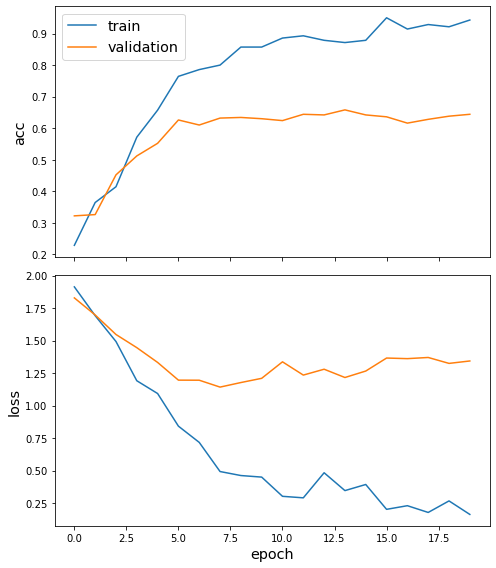

In [21]:
sg.utils.plot_history(history)


In [22]:
test_gen = generator.flow(test_labels.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 0s 9ms/step - loss: 1.3301 - acc: 0.6364

Test Set Metrics:
	loss: 1.3301
	acc: 0.6364


In [23]:
predictions_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(predictions)
# Notice that we have removed the first dimension
predictions, predictions_flat

(<tf.Tensor 'dense/truediv:0' shape=(1, None, 7) dtype=float32>,
 <tf.Tensor 'lambda_1/Squeeze:0' shape=(None, 7) dtype=float32>)

In [24]:
model_predict = Model(inputs=x_inp, outputs=predictions_flat)
all_nodes = list(G.nodes())
all_gen = generator.flow(all_nodes, name="all_gen")
all_predictions = model_predict.predict(all_gen)
all_predictions.shape

(2708, 7)

In [25]:
node_predictions = target_encoding.inverse_transform(all_predictions)
len(all_gen.node_order)

2708

In [26]:
results = pd.Series(node_predictions, index=all_gen.node_order)
df = pd.DataFrame({"Predicted": results, "True": labels})
df.head(10)

Predicted                    True
35       Genetic_Algorithms      Genetic_Algorithms
40       Genetic_Algorithms      Genetic_Algorithms
114  Reinforcement_Learning  Reinforcement_Learning
117  Reinforcement_Learning  Reinforcement_Learning
128  Reinforcement_Learning  Reinforcement_Learning
130  Reinforcement_Learning  Reinforcement_Learning
164                  Theory                  Theory
288  Reinforcement_Learning  Reinforcement_Learning
424              Case_Based           Rule_Learning
434         Neural_Networks  Reinforcement_Learning

In [27]:
x_out_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(x_out)
embedding_model = Model(inputs=x_inp, outputs=x_out_flat)
emb = embedding_model.predict(all_gen, verbose=1)
emb.shape

5/5 [==============================] - 0s 8ms/step


(2708, 32)

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

C:\Users\Song1\anaconda3\envs\stellargraph\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Song1\anaconda3\envs\stellargraph\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


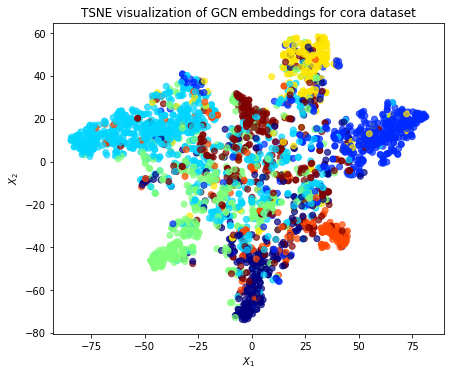

In [29]:
X = emb
y = np.argmax(
    target_encoding.transform(labels.reindex(index=all_gen.node_order)), axis=1,
)
if X.shape[1] > 2:
    transform = TSNE  # or use PCA for speed

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=all_gen.node_order)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GCN embeddings for cora dataset".format(transform.__name__)
)
plt.show()